1. Загрузите данные и разделите на слова.
2. Создайте словарь и превратите данные в индексы.
3. Превратите данные в обучающую выборку.
4. Напишите нейронные сети.

Четыре нейронки, которые нужно написать:
1. Embedding + Dense сеть.
2. Embedding + LSTM сеть.
3. Embedding + Conv1D сеть.
4. Embedding + сложная сеть из Dense, LSTM и Conv1D

# Импортирование библиотек

In [ ]:
from google.colab import files, drive
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
%matplotlib inline
 
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
 
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
 
from sklearn.model_selection import train_test_split
 
import seaborn as sns
sns.set_style('darkgrid')

# Импортирование данных с Гугл диска

In [ ]:
now = time.time()

drive.mount('/content/drive')
!rm '/content/texts'
!unzip -q '/content/drive/MyDrive/Lessons/Lesson4/Тексты писателей.zip' -d '/content/texts'

print(f"Время обработки: {round(time.time() - 2, 2)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
rm: cannot remove '/content/texts': No such file or directory
Время обработки: 1630478314.48


# Создание функций для работы с данными

In [ ]:
def readText(fileName):
  file = open(fileName, 'r')
  text = file.read()
  text.replace('\n', ' ')
  
  return text

In [ ]:
def getSet(wordIndex, xLen, step):
  sample = []
  wordLen = len(wordIndex)
  index = 0

  while (index + xLen <= wordLen):
    sample.append(wordIndex[index:index + xLen])
    index += step
  
  return sample

In [ ]:
def getBigSet(wordIndex, xLen, step):
  authorN = len(wordIndex)
  samples = []
  
  for words in wordIndex:
    samples.append(getSet(words, xLen, step))

  xSample = []
  ySample = []

  for ii in range(authorN):
    yCor = utils.to_categorical(ii, authorN)
    for jj in range(len(samples[ii])):  
      xSample.append(samples[ii][jj])
      ySample.append(yCor)

    # for t in range(nClasses):
    # xT = classesXSamples[t]
    # for i in range(len(xT)):
    #   xSamples.append(xT[i])
    #   ySamples.append(utils.to_categorical(t, nClasses))

  return np.array(xSample), np.array(ySample)

In [ ]:
def getTestSet(wordIndex, xLen, step, tokenizer):

  authorN = len(wordIndex)
  classOne = []
  classTwo = []

  for text in wordIndex:
    sample = getSet(text, xLen, step)
    classOne.append(np.array(sample))
    classTwo.append(np.array(tokenizer.sequences_to_matrix(sample)))

  return classOne, classTwo

In [ ]:
def multiTest(model, xTest, name):
  print("НЕЙРОНКА: ", name)
  print('-'*20)
  
  totalSumRec = 0
  
  for i in range(nClasses):
    currPred = model.predict(xTest[i])

    currOut = np.argmax(currPred, axis=1)

    evVal = []
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))

    totalSumRec += len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal)
    
    isRecognized = "Это НЕПРАВИЛЬНЫЙ ответ!"
    if (recognizedClass == i):
      isRecognized = "Это ПРАВИЛЬНЫЙ ответ!"
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')
  
  print()
  sumCount = 0
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print("Средний процент распознавания ",
        int(100*totalSumRec/sumCount),
        "%",
        sep='')

  print()
  
  return totalSumRec/sumCount

  

# Функция для создания модели

In [ ]:
def createModel(maxWordsCount=20000, xLen=1000, level=1):
  model = Sequential()

  model.add(Embedding(maxWordsCount, 5, input_length=xLen))
  model.add(SpatialDropout1D(0.2))
  model.add(BatchNormalization())

  if level not in [1, 2, 3, 4]:
    level = 1

  if level == 1:
    model.add(SimpleRNN(4))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))

  if level == 2:
    model.add(LSTM(4))

  if level == 3:
    model.add(Conv1D(20, 5, activation='relu', padding='same'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Flatten())

  if level == 4:
    model.add(LSTM(4, return_sequences=1))
    model.add(Dense(100, activation='relu'))
    model.add(Conv1D(20, 5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Flatten())


  model.add(Dense(6, activation="softmax"))

  model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  model.summary()

  return model

# Функция для отображения данных

In [ ]:
def showPicture(history):

  plt.figure(figsize = (14, 7))
  plt.plot(history.history['loss'], 
          label='Значение ошибки на обучающем наборе')
  plt.plot(history.history['val_loss'], 
          label='Значение ошибки на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Значение ошибки')
  plt.legend()
  plt.show()

  plt.figure(figsize = (14, 7))
  plt.plot(history.history['accuracy'], 
          label='Доля верных ответов на обучающем наборе')
  plt.plot(history.history['val_accuracy'], 
          label='Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.show()

# Обработка данных

In [ ]:
autorsNames = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"]
trainText = []
testText = []


In [ ]:
for name in autorsNames:
  for text in os.listdir('texts/Тексты писателей'):
    if name in text:
      if "Обучающая" in text:
        trainText.append(readText('texts/Тексты писателей/' + text))
        print(text, " - добавлен в обучающую выборку")
      elif "Тестовая" in text:
        testText.append(readText('texts/Тексты писателей/' + text))
        print(text, " - добавлен в тестовую выборку")       
  print()

(О. Генри) Обучающая_50 вместе.txt  - добавлен в обучающую выборку
(О. Генри) Тестовая_20 вместе.txt  - добавлен в тестовую выборку

(Стругацкие) Тестовая_2 вместе.txt  - добавлен в тестовую выборку
(Стругацкие) Обучающая_5 вместе.txt  - добавлен в обучающую выборку

(Булгаков) Обучающая_5 вместе.txt  - добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt  - добавлен в тестовую выборку

(Клиффорд_Саймак) Обучающая_5 вместе.txt  - добавлен в обучающую выборку
(Клиффорд_Саймак) Тестовая_2 вместе.txt  - добавлен в тестовую выборку

(Макс Фрай) Тестовая_2 вместе.txt  - добавлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt  - добавлен в обучающую выборку

(Рэй Брэдберри) Обучающая_22 вместе.txt  - добавлен в обучающую выборку
(Рэй Брэдберри) Тестовая_8 вместе.txt  - добавлен в тестовую выборку



In [ ]:
maxWordsCount = 20000
xLen, step = 1000, 100

tokenizer = Tokenizer(num_words=maxWordsCount,
                      filters='–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff',
                      lower=True,
                      char_level=False,
                      oov_token="noName",
                      split=' ')

tokenizer.fit_on_texts(trainText)

trainWordIndex = tokenizer.texts_to_sequences(trainText)
testWordIndex = tokenizer.texts_to_sequences(testText)

xTrain, yTrain = getBigSet(trainWordIndex, xLen, step)
xTest, yTest = getBigSet(testWordIndex, xLen, step)


In [ ]:
print(xTest.shape)

In [ ]:
xTestOne, xTestTwo = getTestSet(testWordIndex, xLen, step, tokenizer)

# Эксперимент 1 (Embedding + Dense)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 5)           100000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1000, 5)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1000, 5)           20        
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 4)                 40        
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 100)               500       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6

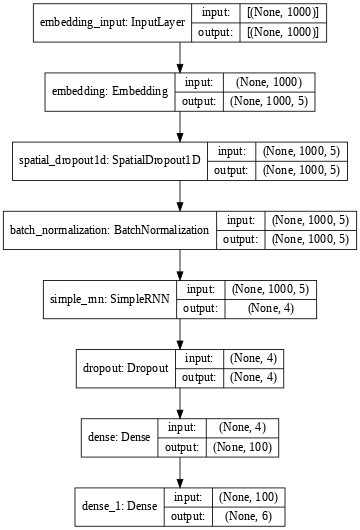

In [ ]:
model = createModel(level=1)

plot_model(model, dpi=60, show_shapes=True)

Epoch 1/50
35/35 [==============================] - 17s 429ms/step - loss: 1.7437 - accuracy: 0.2885 - val_loss: 1.7469 - val_accuracy: 0.2928
Epoch 2/50
35/35 [==============================] - 15s 425ms/step - loss: 1.6941 - accuracy: 0.3217 - val_loss: 1.7370 - val_accuracy: 0.2928
Epoch 3/50
35/35 [==============================] - 15s 437ms/step - loss: 1.6737 - accuracy: 0.3282 - val_loss: 1.7331 - val_accuracy: 0.2913
Epoch 4/50
35/35 [==============================] - 15s 438ms/step - loss: 1.6544 - accuracy: 0.3387 - val_loss: 1.7363 - val_accuracy: 0.2888
Epoch 5/50
35/35 [==============================] - 15s 436ms/step - loss: 1.6255 - accuracy: 0.3541 - val_loss: 1.7400 - val_accuracy: 0.2697
Epoch 6/50
35/35 [==============================] - 15s 434ms/step - loss: 1.5996 - accuracy: 0.3680 - val_loss: 1.7380 - val_accuracy: 0.2791
Epoch 7/50
35/35 [==============================] - 15s 426ms/step - loss: 1.5697 - accuracy: 0.3794 - val_loss: 1.7421 - val_accuracy: 0.2665

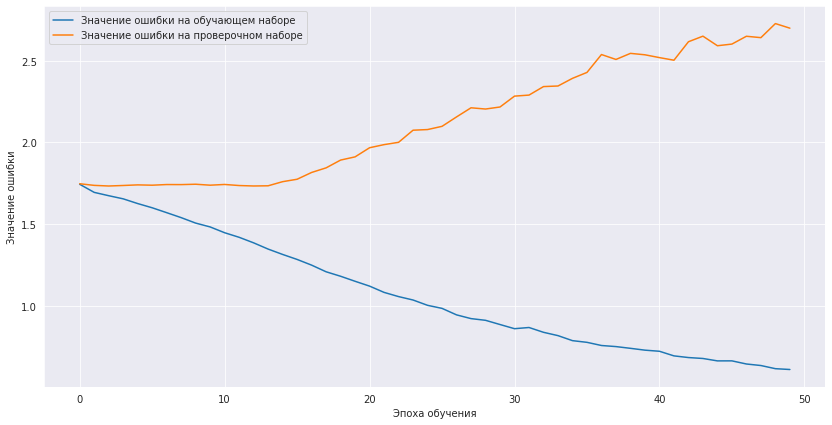

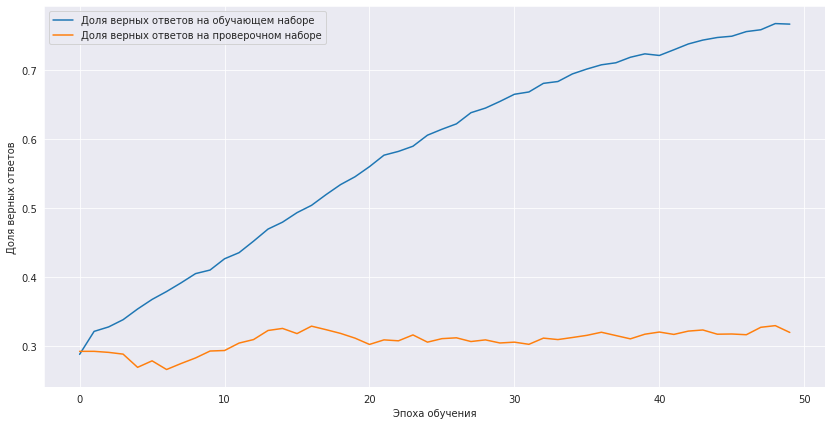

In [ ]:
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=50,
                    batch_size=512,
                    validation_data=(xTest, yTest),
                    verbose=1)

showPicture(history)

На графике заметно переобучение

# Эксперимент 2 (Embedding + LSTM)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 5)           100000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1000, 5)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 5)           20        
_________________________________________________________________
lstm (LSTM)                  (None, 4)                 160       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 30        
Total params: 100,210
Trainable params: 100,200
Non-trainable params: 10
_________________________________________________________________


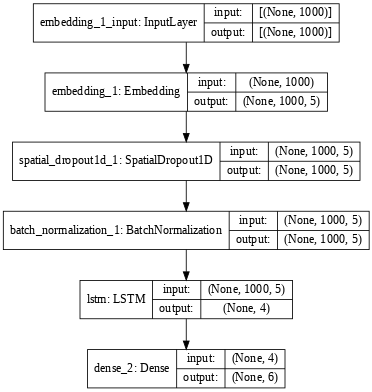

In [ ]:
model = createModel(level=2)

plot_model(model, dpi=60, show_shapes=True)

Epoch 1/50
35/35 [==============================] - 26s 693ms/step - loss: 1.7616 - accuracy: 0.2614 - val_loss: 1.7691 - val_accuracy: 0.2928
Epoch 2/50
35/35 [==============================] - 24s 673ms/step - loss: 1.6668 - accuracy: 0.3558 - val_loss: 1.7476 - val_accuracy: 0.2928
Epoch 3/50
35/35 [==============================] - 24s 687ms/step - loss: 1.5802 - accuracy: 0.3838 - val_loss: 1.7362 - val_accuracy: 0.2928
Epoch 4/50
35/35 [==============================] - 24s 684ms/step - loss: 1.4864 - accuracy: 0.4265 - val_loss: 1.8383 - val_accuracy: 0.2928
Epoch 5/50
35/35 [==============================] - 24s 691ms/step - loss: 1.3820 - accuracy: 0.4795 - val_loss: 1.8497 - val_accuracy: 0.2909
Epoch 6/50
35/35 [==============================] - 24s 695ms/step - loss: 1.2961 - accuracy: 0.5118 - val_loss: 1.6553 - val_accuracy: 0.2755
Epoch 7/50
35/35 [==============================] - 24s 693ms/step - loss: 1.2526 - accuracy: 0.5345 - val_loss: 1.7197 - val_accuracy: 0.2307

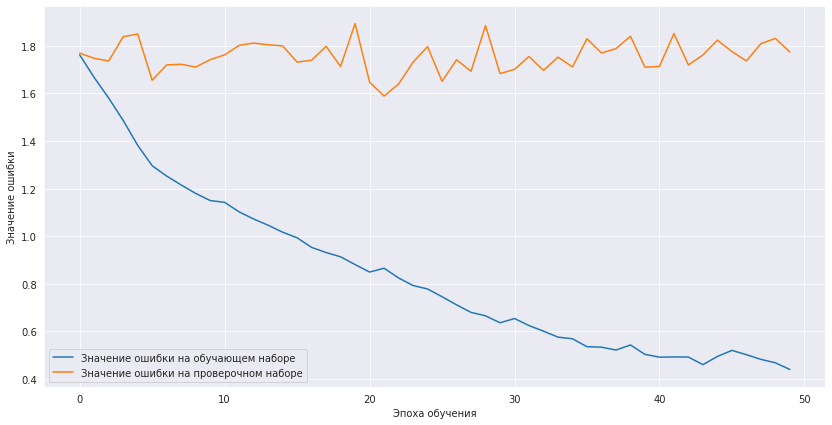

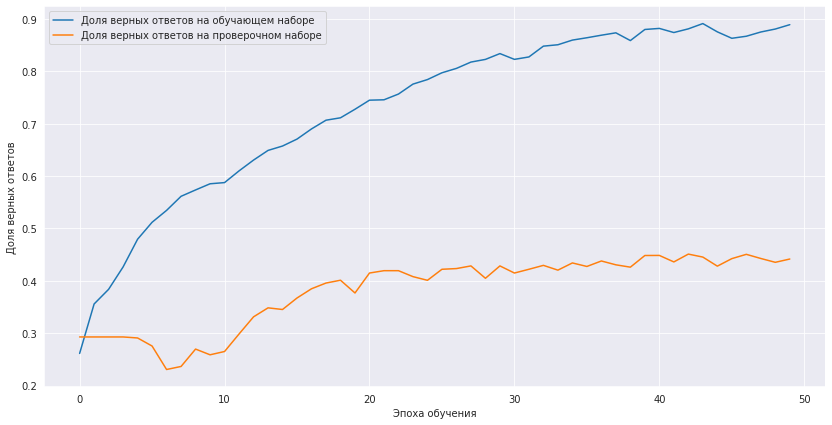

In [ ]:
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=50,
                    batch_size=512,
                    validation_data=(xTest, yTest),
                    verbose=1)

showPicture(history)

Явного переобучения нет

# Эксперимент 3 (Embedding + Conv1D)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 5)           100000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 1000, 5)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000, 5)           20        
_________________________________________________________________
conv1d (Conv1D)              (None, 1000, 20)          520       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 500, 20)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 20)           0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 500, 20)          

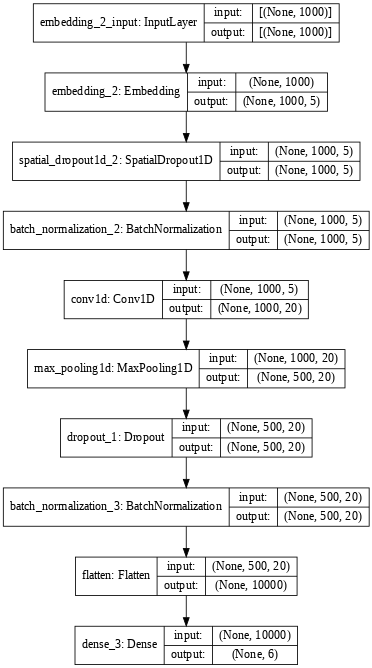

In [ ]:
model = createModel(level=3)

plot_model(model, dpi=60, show_shapes=True)

Epoch 1/50
35/35 [==============================] - 21s 567ms/step - loss: 1.4975 - accuracy: 0.4736 - val_loss: 1.7945 - val_accuracy: 0.2928
Epoch 2/50
35/35 [==============================] - 19s 556ms/step - loss: 0.2904 - accuracy: 0.8951 - val_loss: 2.1576 - val_accuracy: 0.2928
Epoch 3/50
35/35 [==============================] - 19s 546ms/step - loss: 0.0885 - accuracy: 0.9703 - val_loss: 2.3213 - val_accuracy: 0.2928
Epoch 4/50
35/35 [==============================] - 20s 562ms/step - loss: 0.0628 - accuracy: 0.9788 - val_loss: 3.0844 - val_accuracy: 0.2928
Epoch 5/50
35/35 [==============================] - 20s 584ms/step - loss: 0.0449 - accuracy: 0.9862 - val_loss: 3.4426 - val_accuracy: 0.2621
Epoch 6/50
35/35 [==============================] - 19s 557ms/step - loss: 0.0436 - accuracy: 0.9849 - val_loss: 4.6688 - val_accuracy: 0.2928
Epoch 7/50
35/35 [==============================] - 19s 550ms/step - loss: 0.0392 - accuracy: 0.9879 - val_loss: 3.2694 - val_accuracy: 0.4146

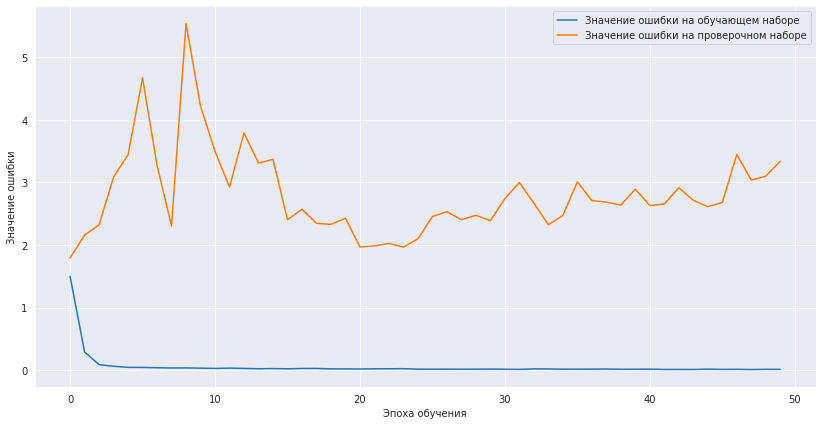

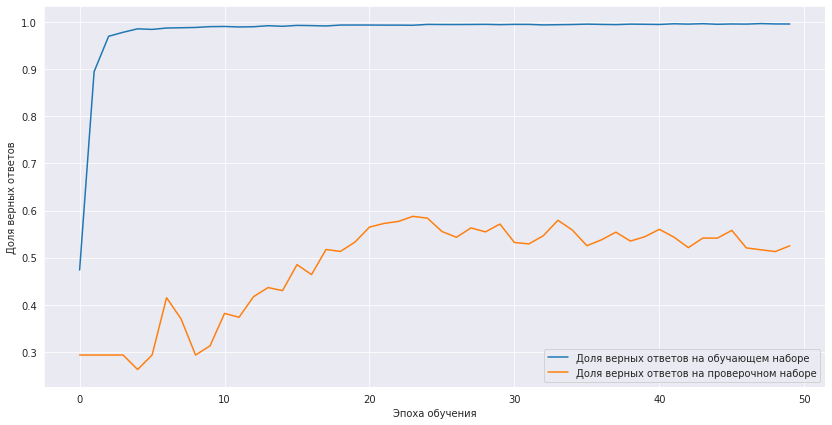

In [ ]:
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=50,
                    batch_size=512,
                    validation_data=(xTest, yTest),
                    verbose=1)

showPicture(history)

Слабый тренд на переобучение

# Эксперимент 4 (Embedding + сложная сеть из Dense, LSTM и Conv1D)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 5)           100000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 1000, 5)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1000, 5)           20        
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 4)           160       
_________________________________________________________________
dense_4 (Dense)              (None, 1000, 100)         500       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 20)           10020     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 498, 20)          

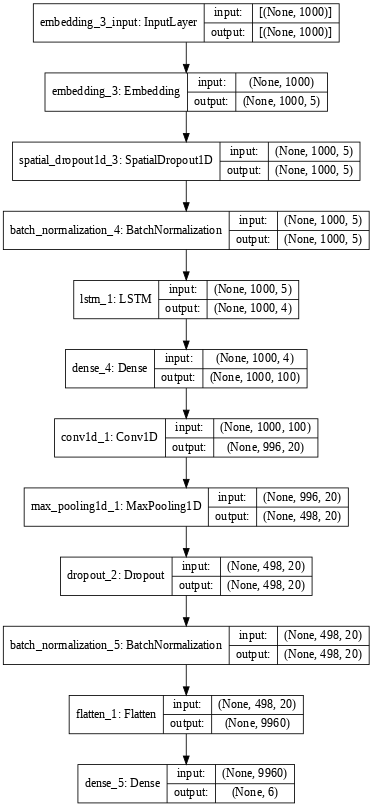

In [ ]:
model = createModel(level=4)

plot_model(model, dpi=60, show_shapes=True)


Epoch 1/50
35/35 [==============================] - 109s 3s/step - loss: 1.1942 - accuracy: 0.5172 - val_loss: 2.4788 - val_accuracy: 0.0738
Epoch 2/50
35/35 [==============================] - 113s 3s/step - loss: 0.3003 - accuracy: 0.8977 - val_loss: 3.1081 - val_accuracy: 0.0738
Epoch 3/50
35/35 [==============================] - 109s 3s/step - loss: 0.1396 - accuracy: 0.9584 - val_loss: 3.3859 - val_accuracy: 0.0738
Epoch 4/50
35/35 [==============================] - 106s 3s/step - loss: 0.0770 - accuracy: 0.9767 - val_loss: 3.6064 - val_accuracy: 0.1611
Epoch 5/50
35/35 [==============================] - 105s 3s/step - loss: 0.0583 - accuracy: 0.9818 - val_loss: 3.3794 - val_accuracy: 0.0753
Epoch 6/50
35/35 [==============================] - 107s 3s/step - loss: 0.0426 - accuracy: 0.9869 - val_loss: 3.6283 - val_accuracy: 0.1191
Epoch 7/50
35/35 [==============================] - 109s 3s/step - loss: 0.0374 - accuracy: 0.9887 - val_loss: 4.0800 - val_accuracy: 0.1611
Epoch 8/50
35

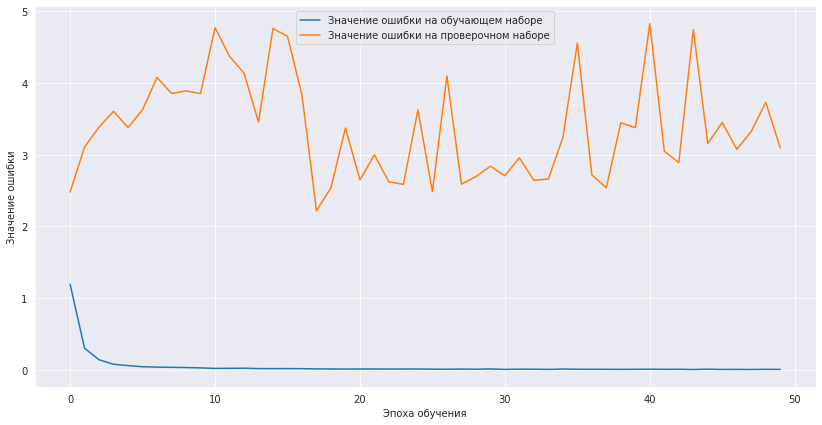

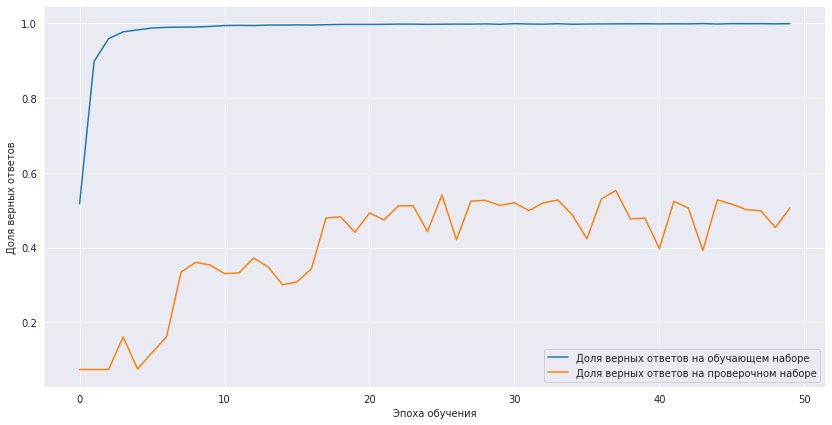

In [ ]:
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=50,
                    batch_size=512,
                    validation_data=(xTest, yTest),
                    verbose=1)

showPicture(history)

Нет явного переобучения